# Import Library

In [1]:
# Instalasi library
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.0 MB/s eta 0:00:00


In [2]:
# basic library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import emoji

from tqdm import tqdm
tqdm.pandas()

import joblib

# buat prosessing teks
import requests
import string
import json
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as download_nltk

# download dependensi NLTK
download_nltk('punkt')
download_nltk('punkt_tab')
download_nltk('stopwords')

# Deeplearning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataet

In [3]:
# google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/submission/NLP/data"
path_model = "/content/drive/MyDrive/submission/NLP/model"

In [5]:
df = pd.read_csv(f'{path}/tiktok_reviews.csv')
df

,content,score
0,bisa ga sih perbaiki bug yang ada di tiktok in...,2
1,"aplikasi nya sudah baguss bgt, lebih dari bagu...",4
2,"aplikasi ini bagus sekali, cuma kalau belanja ...",1
3,kenapa sekarang jadi suka ngeleg si setelah up...,1
4,Tolong kepada pihak tiktok mengapa masih ada s...,5
...,...,...
19995,Salah satu hal yg bikin ribet dari ui tiktok t...,3
19996,"aneh, dibuka gabisa di pencet penc3t berkahli ...",2
19997,"alhamdulilah, sejauh ini baik' saja, tapi dimo...",4
19998,"Tiktok banyak bug cokk, apaan coba gw pake aku...",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# Preprosessing

## Clean Text

In [7]:
# bersihkan text dari tanda baca & emoji
def cleaningText(text):
  # huruf kecil
  text = text.lower()

  # hapus mention hastag dan RT
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#[A-Za-z0-9]+', '', text)
  text = re.sub(r'\brt\b', '', text)

  # hapus URL
  text = re.sub(r"http\S+|www.\S+", '', text)

  # hapus angka
  text = re.sub(r'\d+', '', text)

  # hapus semua emoji
  text = emoji.replace_emoji(text, replace='')

  # hapus tanda baca
  text = text.translate(str.maketrans('', '', string.punctuation))

  # hapus spasi
  text = text.strip()
  text = re.sub(r'\s+', ' ', text)

  return text

## Menemukan Kata slang

In [8]:
def find_candidate_slang(df, text_col, top_n=50):
  """
  Mendeteksi kata-kata yang sering muncul dan bisa jadi slang.

  Parameters:
  - df: DataFrame dengan kolom teks ulasan
  - text_col: Nama kolom teks
  - top_n: Berapa banyak kata teratas yang ditampilkan

  Returns:
  - DataFrame kata + frekuensi
  """
  # Gabungkan semua teks
  all_text = ' '.join(df[text_col].astype(str).tolist()).lower()

  # Tokenisasi dan bersihkan
  tokens = word_tokenize(all_text)
  tokens = [t for t in tokens if t.isalpha()]  # buang angka & simbol

  # Filter stopwords
  stop_words = set(stopwords.words('indonesian'))
  filtered_tokens = [word for word in tokens if word not in stop_words]

  # Hitung frekuensi
  counter = Counter(filtered_tokens)
  freq_df = pd.DataFrame(counter.items(), columns=['Word', 'Frequency'])
  freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

  return freq_df.head(top_n)

In [9]:
candidate_slang = find_candidate_slang(df, 'content', top_n=100)
print(candidate_slang)

         Word  Frequency
0      tiktok      16717
1         nya      11509
2      tolong       7379
3    aplikasi       6048
4        buka       5641
..        ...        ...
95  tiktoknya        573
96          d        559
97     kecewa        554
98         si        532
99        tau        528

[100 rows x 2 columns]


In [10]:
df_sample = df.sample(n=1000, random_state=3)
df_sample['score'].value_counts()

,count
score,
1,398
3,168
2,166
5,163
4,105


In [11]:
candidate_slang = find_candidate_slang(df_sample, 'content', top_n=100)
print(candidate_slang)

           Word  Frequency
0        tiktok        815
1           nya        577
2        tolong        368
3      aplikasi        289
4          buka        286
..          ...        ...
95      benerin         29
96  pelanggaran         29
97         kaya         29
98       pencet         29
99         mati         28

[100 rows x 2 columns]


## Slang Ke Baku

In [12]:
with open(f'{path}/slang.json', 'r') as f:
  slang2baku = json.load(f)
slang2baku['kenap']

'kenapa'

In [13]:
# jika ingin menambahkan lagi
slang2baku.update({
  "ngga": "tidak",
  "kayak": "seperti",
  "emang" : "memang",
  'gaes' : "guys",
  'gais' : "guys",
  'ges':"guys",
  'gess' :'guys',
  'elo' : 'kamu',
  'bgtt': 'banget',
  'btw' : 'ngomong-ngomong',
  'tsb': 'tersebut',
  'hahaha': 'tertawa',
  'bgs' : 'bagus',
  'bagu' : 'bagus',
  'bags' : 'bagus',
  'bgus' : 'bagus',
  'skrg' : 'sekarang',
  'skrang' : 'sekarang',
  'skarang' : 'sekarang',
  'skarg' : 'sekarang' ,
  'sekrg' : 'sekarang',
  'tt' : 'tiktok',
  'ngestuk' :'berhenti',
  'doangg' : 'hanya',
  'knapa' : 'kenapa',
  'kenap' : 'kenapa',
  'kenpa' : 'kenapa',
  'knp': 'kenapa'
})

# 3. Simpan lagi
with open('/content/slang.json', 'w') as f:
  json.dump(slang2baku, f, indent=2)

with open('/content/slang.json', 'r') as f:
  slang2baku = json.load(f)
slang2baku['gess']

'guys'

In [14]:
# KEDUA : slang to baku
def handle_slang2baku(text):
  words = text.split()
  fixed_words = []

  for word in words:
    if word.lower() in slang2baku:
      fixed_words.append(slang2baku[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)
  return fixed_text

## Tokenisasi

In [15]:
# tokenisasi
def tokenisasi(text):
  text = word_tokenize(text)
  return text

## Hapus Stopword

In [16]:
# hapus stopword
def hapus_stopword(text): # Remove stopwors in a text
  listStopwords = set(stopwords.words('indonesian'))
  listStopwords1 = set(stopwords.words('english'))

  merge_stopwords = listStopwords.union(listStopwords1)

  new_stopword = set([
    'rb', 'nya', 'nyaa', 'ya', 'yaa',
    'woi', 'woy', 'woii', 'deh', 'sih', 'kan', 'lah', 'nih', 'loh', 'kah', 'aja',
    'si', 'nya', 'ku', 'c', 'nih', 'eh',
    'kali', 'dong', 'please' ,'katanya'
  ])

  # gabungin
  semua_stopwords = merge_stopwords.union(new_stopword)

  # HAPUS kata-kata penting dari stopword
  kata_penting = {
    'ini', 'itu', 'tersebut'
  }
  semua_stopwords = semua_stopwords - kata_penting

  if isinstance(text, str):
    text = text.split()

  # Hapus stopwords
  filtered = [word for word in text if word.lower() not in semua_stopwords]

  return filtered

In [17]:
'guys' in set(stopwords.words('english'))

False

In [18]:
'ini' in set(stopwords.words('indonesian'))

True

## Kata Ke Kalimat

In [19]:
# final teks gabungin jadi 1 kalimat
def keKalimat(list_words):
  kalimat = ' '.join(word for word in list_words)
  return kalimat

In [20]:
teks_contoh = "TikTok keren bgt 😍🔥💯 #FYP @tiktok http://link btw ini aplikasi juga sampah sih hahaha"

def contoh_preprosesing(teks):
  teks = cleaningText(teks)
  teks = handle_slang2baku(teks)
  teks = tokenisasi(teks)
  teks = hapus_stopword(teks)
  teks = keKalimat(teks)
  return teks

print(contoh_preprosesing(teks_contoh))

tiktok keren banget ngomong-ngomong ini aplikasi sampah tertawa


In [21]:
df_clean = df.copy()

In [22]:
df_clean['df_clean'] = df_clean['content'].progress_apply(cleaningText)
df_clean['df_slang2baku'] = df_clean['df_clean'].progress_apply(handle_slang2baku)
df_clean['df_tokenisasi'] = df_clean['df_slang2baku'].progress_apply(tokenisasi)
df_clean['df_stopword'] = df_clean['df_tokenisasi'].progress_apply(hapus_stopword)
df_clean['df_final'] = df_clean['df_stopword'].progress_apply(keKalimat)

100%|██████████| 20000/20000 [00:00<00:00, 383659.87it/s]


In [23]:
df_clean.head(1)

,content,score,df_clean,df_slang2baku,df_tokenisasi,df_stopword,df_final
0,bisa ga sih perbaiki bug yang ada di tiktok in...,2,bisa ga sih perbaiki bug yang ada di tiktok in...,bisa tidak perbaiki bug yang ada di tiktok in...,"[bisa, tidak, perbaiki, bug, yang, ada, di, ti...","[perbaiki, bug, tiktok, ini, kadang, masuk, ap...",perbaiki bug tiktok ini kadang masuk aplikasi ...


## Pelabelan

In [24]:
df_reviews = df_clean.copy()

In [25]:
np.__version__

'2.0.2'

### Membuat Lexicon Untuk Labeling (Positif & Negatif)

In [27]:
def unduh_lexikon(url):
  try:
    response = requests.get(url)
    response.raise_for_status()
    return {baris.strip() for baris in response.text.splitlines() if baris.strip()}
  except requests.RequestException as e:
    print(f"Terjadi kesalahan saat mengunduh dari {url}:\n{e}")
    return set()

# URL sumber leksikon
daftar_url = {
  "positif": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt",
  "negatif": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
}

# Mengambil leksikon
lexikon_positif = unduh_lexikon(daftar_url["positif"])
lexikon_negatif = unduh_lexikon(daftar_url["negatif"])

# Output statistik
print("Total Kata positif:", len(lexikon_positif))
print("Total Kaata negatif:", len(lexikon_negatif))


Total Kata positif: 1182
Total Kaata negatif: 2402


In [28]:
df_reviews.head()

,content,score,df_clean,df_slang2baku,df_tokenisasi,df_stopword,df_final
0,bisa ga sih perbaiki bug yang ada di tiktok in...,2,bisa ga sih perbaiki bug yang ada di tiktok in...,bisa tidak perbaiki bug yang ada di tiktok in...,"[bisa, tidak, perbaiki, bug, yang, ada, di, ti...","[perbaiki, bug, tiktok, ini, kadang, masuk, ap...",perbaiki bug tiktok ini kadang masuk aplikasi ...
1,"aplikasi nya sudah baguss bgt, lebih dari bagu...",4,aplikasi nya sudah baguss bgt lebih dari bagus...,aplikasi sudah baguss banget lebih dari bagus...,"[aplikasi, sudah, baguss, banget, lebih, dari,...","[aplikasi, baguss, banget, bagus, tpii, membuk...",aplikasi baguss banget bagus tpii membuka apli...
2,"aplikasi ini bagus sekali, cuma kalau belanja ...",1,aplikasi ini bagus sekali cuma kalau belanja d...,aplikasi ini bagus sekali hanya kalau belanja ...,"[aplikasi, ini, bagus, sekali, hanya, kalau, b...","[aplikasi, ini, bagus, belanja, tiktok, shop, ...",aplikasi ini bagus belanja tiktok shop mengece...
3,kenapa sekarang jadi suka ngeleg si setelah up...,1,kenapa sekarang jadi suka ngeleg si setelah up...,kenapa sekarang jadi suka lemot si setelah pem...,"[kenapa, sekarang, jadi, suka, lemot, si, sete...","[suka, lemot, pembaruan, ponsel, ulang, mati, ...",suka lemot pembaruan ponsel ulang mati berkali...
4,Tolong kepada pihak tiktok mengapa masih ada s...,5,tolong kepada pihak tiktok mengapa masih ada s...,tolong kepada pihak tiktok mengapa masih ada s...,"[tolong, kepada, pihak, tiktok, mengapa, masih...","[tolong, tiktok, bug, alami, pencarian, video,...",tolong tiktok bug alami pencarian video memuta...


In [29]:
# Fungsi untuk menentukan label sentimen berdasarkan leksikon
def hitung_sentimen(kalimat):
  skor = sum(1 for kata in kalimat if kata in lexikon_positif) - sum(1 for kata in kalimat if kata in lexikon_negatif)

  if skor > 0:
    return skor, "positif"
  elif skor < 0:
    return skor, "negatif"
  else:
    return skor, "netral"

# Terapkan ke kolom teks (yang sudah dihapus stopword)
df_reviews[['sentimen_skor', 'sentimen']] = df_reviews['df_stopword'].apply(hitung_sentimen).apply(pd.Series)

# Menampilkan sentimen
df_reviews['sentimen'].value_counts()


,count
sentimen,
negatif,6998
netral,6566
positif,6436


### Visualisasi

In [ ]:
def generate_wordcloud_by_label(df, text_column='df_final', label_column='sentimen'):
  # Mapping warna berdasarkan label
  label_config = {
    'negatif': {'color': 'Reds', 'title': 'Negatif'},
    'netral': {'color': 'Greys', 'title': 'Netral'},
    'positif': {'color': 'Greens', 'title': 'Positif'},
  }

  plt.figure(figsize=(18, 6))

  for i, (label, config) in enumerate(label_config.items()):
      text = ' '.join(df[df[label_column] == label][text_column].astype(str))
      wordcloud = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap=config['color']
      ).generate(text)

      plt.subplot(1, 3, i + 1)
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis('off')
      plt.title(f'WordCloud: {config["title"]}', fontsize=14)

  plt.tight_layout()
  plt.show

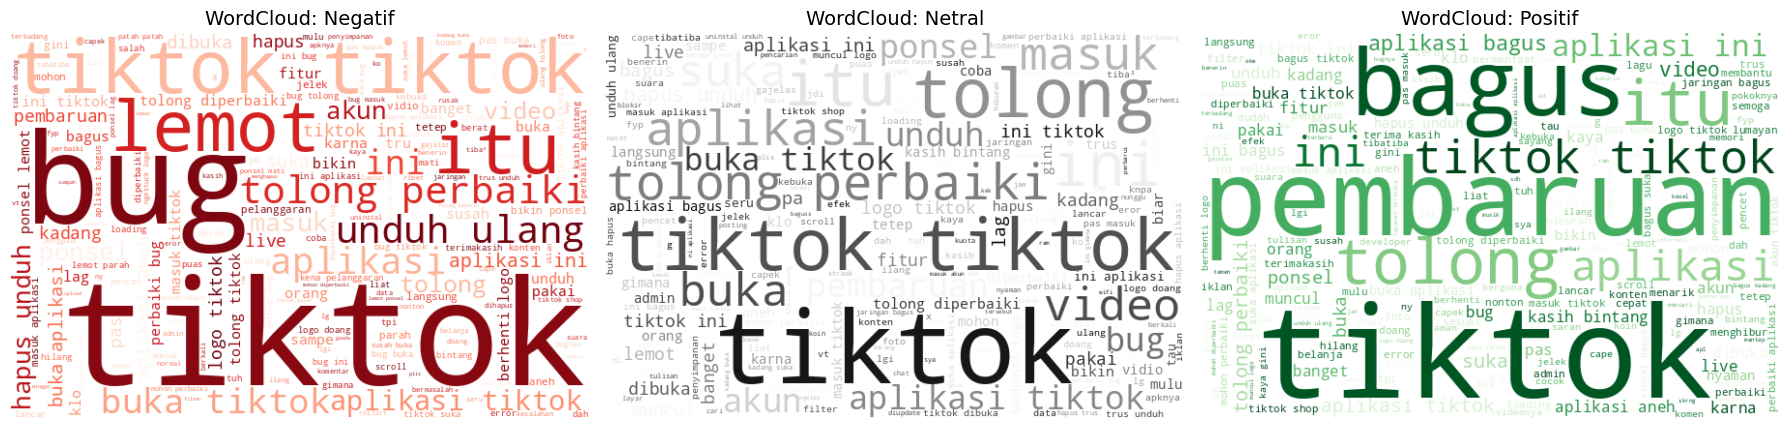

In [ ]:
generate_wordcloud_by_label(df_reviews)

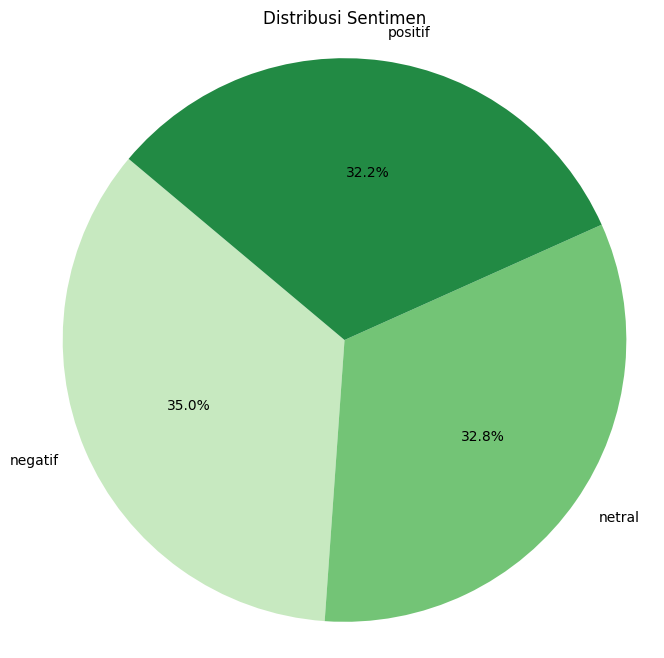

In [32]:
# Menghitung distribusi sentimen
distribusi = df_reviews['sentimen'].value_counts().sort_index()

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 8))
warna = sns.color_palette("Greens", n_colors=len(distribusi))

ax.pie(
    x=distribusi.values,
    labels=distribusi.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=warna
)

ax.set_title('Distribusi Sentimen')
ax.axis('equal')  # Menjaga bentuk pie tetap bulat
plt.show()

In [33]:
df_reviews[df_reviews['sentimen'] == 'netral'].head()

,content,score,df_clean,df_slang2baku,df_tokenisasi,df_stopword,df_final,sentimen_skor,sentimen
5,kenapa sekarang setiap kali upload video malah...,3,kenapa sekarang setiap kali upload video malah...,kenapa sekarang setiap kali upload video malah...,"[kenapa, sekarang, setiap, kali, upload, video...","[upload, video, burikpadahal, video, aslinya, ...",upload video burikpadahal video aslinya jernih...,0,netral
12,Semoga admin membaca ulasan ini serta memperti...,3,semoga admin membaca ulasan ini serta memperti...,semoga admin membaca ulasan ini serta memperti...,"[semoga, admin, membaca, ulasan, ini, serta, m...","[semoga, admin, membaca, ulasan, ini, memperti...",semoga admin membaca ulasan ini mempertimbangk...,0,netral
20,"gajelas bngt tiktok, masa abis di update beber...",1,gajelas bngt tiktok masa abis di update bebera...,gajelas bngt tiktok masa abis di pembaruan beb...,"[gajelas, bngt, tiktok, masa, abis, di, pembar...","[gajelas, bngt, tiktok, abis, pembaruan, video...",gajelas bngt tiktok abis pembaruan video gelap...,0,netral
33,"sebenarnya tiktok ini udah bagus aja, cuma say...",4,sebenarnya tiktok ini udah bagus aja cuma saya...,sebenarnya tiktok ini sudah bagus saja hanya s...,"[sebenarnya, tiktok, ini, sudah, bagus, saja, ...","[tiktok, ini, bagus, tolong, hilangkan, bug, m...",tiktok ini bagus tolong hilangkan bug masuk ti...,0,netral
34,"aplikasi nya bagus cuma banyak bugnya,kadang h...",1,aplikasi nya bagus cuma banyak bugnyakadang ha...,aplikasi bagus hanya banyak bugnyakadang haru...,"[aplikasi, bagus, hanya, banyak, bugnyakadang,...","[aplikasi, bagus, bugnyakadang, ditunggu, tete...",aplikasi bagus bugnyakadang ditunggu tetep apl...,0,netral


# Persiapan Data

In [34]:
# Pilih kolom sebagai fitur dan label
X = df_reviews.loc[:, 'df_final']
y = df_reviews['sentimen'].replace({'negatif': 0, 'netral': 1, 'positif': 2})

<ipython-input-34-fe8b0d171e92>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_reviews['sentimen'].replace({'negatif': 0, 'netral': 1, 'positif': 2})


In [35]:
X

,df_final
0,perbaiki bug tiktok ini kadang masuk aplikasi ...
1,aplikasi baguss banget bagus tpii membuka apli...
2,aplikasi ini bagus belanja tiktok shop mengece...
3,suka lemot pembaruan ponsel ulang mati berkali...
4,tolong tiktok bug alami pencarian video memuta...
...,...
19995,salah bikin ribet ui tiktok terbaru mampause s...
19996,aneh dibuka pencet penct berkahli bug tiktok a...
19997,alhamdulilah ini dimohon pembaruan kasian memo...
19998,tiktok bug cokk coba pakai akun tersedia twitt...


In [36]:
y

,sentimen
0,0
1,2
2,0
3,0
4,0
...,...
19995,0
19996,0
19997,2
19998,0


# Ektraksi Fitur

## Vektorisasi

In [43]:
# Vektorisasi teks menggunakan TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(X)

# Tampilan hasil variabel diatas
print(vectorizer.get_feature_names_out())
print(X_tfidf.shape)

['aa' 'aaaaaaa' 'aah' ... '𝚠𝚊𝚔𝚝𝚞' '𝚢𝚊𝚗𝚐' '𝚢𝚐']
(20000, 10000)


In [44]:
path_model

'/content/drive/MyDrive/submission/NLP/model'

In [45]:
# Menyimpan vectorizer
joblib.dump(vectorizer, f'{path_model}/tfidf_vectorizer.pkl')

['/content/drive/MyDrive/submission/NLP/model/tfidf_vectorizer.pkl']

## Prapreprosesing

In [46]:
# Tokenisasi teks dan padding
token = Tokenizer(num_words=10000)
token.fit_on_texts(X)

# Ubah teks jadi urutan angka
urutan_teks = token.texts_to_sequences(X)

# Terapkan padding ke panjang maksimum 100
urutan_padding = pad_sequences(urutan_teks, maxlen=100)

In [47]:
path_model

'/content/drive/MyDrive/submission/NLP/model'

In [48]:
# Menyimpan tokenizer ke dalam file .pkl
joblib.dump(token, f'{path_model}/tokenizer.pkl')

['/content/drive/MyDrive/submission/NLP/model/tokenizer.pkl']

In [62]:
print(token)

In [66]:
print(urutan_teks)

[[9, 8, 1, 3, 21, 12, 2, 21, 68, 37, 41, 6, 4, 1, 264, 40, 673, 707, 13, 2, 128, 4, 9, 8, 1, 2129], [2, 221, 37, 6, 2448, 134, 2, 3, 646, 15, 108, 179, 472, 271, 106, 43, 25, 32, 33], [2, 3, 6, 112, 1, 75, 395, 26, 3310, 236, 8547, 1029, 1, 75, 282, 2283, 586, 574, 197, 586, 574, 449, 59, 2283, 633, 1783, 510, 1280, 511, 633, 1374, 3311, 225, 2283, 466, 5753], [15, 17, 10, 11, 22, 73, 290, 1281, 1, 55, 49, 647, 21, 821, 333, 56, 5, 8548, 8549, 1, 441, 196, 5754, 22, 290, 2971, 8550, 22, 2, 1, 17, 1082, 55, 8551, 1326], [4, 1, 8, 840, 215, 16, 1419, 16, 215, 189, 269, 38, 3312, 190, 16, 189, 4, 731, 8, 3], [82, 16, 8552, 16, 1030, 822, 493, 523, 1468, 2, 4468, 1468, 458, 51, 8553, 82, 16, 634, 8554, 9, 45, 5755, 634, 16, 1004], [2, 6, 2701, 26, 15, 14, 5, 2, 15, 8, 38, 19, 1, 35, 133, 14, 11, 73, 152, 7, 22, 91, 103, 1, 49, 9, 2], [697, 270, 15, 2449, 30, 2002, 110, 16, 717, 8555, 270, 189, 674, 3313, 14, 388, 190, 92, 708, 1, 732, 5756, 2702, 270, 15, 16, 4469, 69, 24, 189, 511, 124, 3

In [67]:
print(urutan_padding)

[[   0    0    0 ...    8    1 2129]
 [   0    0    0 ...   25   32   33]
 [   0    0    0 ... 2283  466 5753]
 ...
 [   0    0    0 ... 3834  770   10]
 [   0    0    0 ... 2566   35 1226]
 [   0    0    0 ...  506  124   32]]


# Latih & Evaluasi Model

## LSTM | 80/20 | Word Embedding

### Spliting Data

In [80]:
# Langkah 1: Bagi data jadi 80% latih+validasi dan 20% pengujian
X_sisa, X_test, y_sisa, y_test = train_test_split(
  urutan_padding, y, test_size=0.2, random_state=42
)

# Langkah 2: Dari 80% sisa, ambil 12.5% (10% total data) untuk validasi
X_train, X_val, y_train, y_val = train_test_split(
  X_sisa, y_sisa, test_size=0.125, random_state=42
)

# Tampilkan ukuran masing-masing set
print(f"Jumlah Data Train: {X_train.shape[0]}")
print(f"Jumlah Data Validasi : {X_val.shape[0]}")
print(f"Jumalh Data Test: {X_test.shape[0]}")


Jumlah Data Train: 14000
Jumlah Data Validasi : 2000
Jumalh Data Test: 4000


### Latih LSTM

In [70]:
# Arsitektur model LSTM untuk klasifikasi 3 kelas sentimen
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model_LSTM.add(SpatialDropout1D(0.4))
model_LSTM.add(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3))
model_LSTM.add(Dense(units=3, activation='softmax'))

# Kompilasi model
model_LSTM.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callback: early stopping & learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Latih model
riwayat_latihan = model_LSTM.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=15,
  batch_size=64,
  verbose=1,
  callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 391ms/step - accuracy: 0.5500 - loss: 0.9053 - val_accuracy: 0.8355 - val_loss: 0.4647 - learning_rate: 0.0010
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 331ms/step - accuracy: 0.8678 - loss: 0.3712 - val_accuracy: 0.9070 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.9344 - loss: 0.1982 - val_accuracy: 0.9235 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 84s 338ms/step - accuracy: 0.9537 - loss: 0.1417 - val_accuracy: 0.9285 - val_loss: 0.2468 - learning_rate: 0.0010
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.9690 - loss: 0.0990 - val_accuracy: 0.9305 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.9796 - loss: 0.0684 - val_accuracy: 0.9335 - val_loss: 0.2439 - learning_rate: 0.0010
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 86s 357ms/step - accuracy: 0.9794 - lo

### Evaluasi LSTM

In [71]:
# Ambil nilai akurasi pelatihan terakhir
akurasi_latih_terakhir = riwayat_latihan.history['accuracy'][-1]

# Evaluasi terhadap data uji
kerugian_uji, akurasi_uji = model_LSTM.evaluate(X_test, y_test)

# Menampilkan accurasinya
print(f"Akurasi Terakhir Train: {akurasi_latih_terakhir:.4f}")
print(f"Akurasi Terakhir Uji: {akurasi_uji:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9342 - loss: 0.2057

Akurasi Pelatihan Terakhir: 0.9777
Akurasi Pengujian: 0.9330


In [73]:
# Prediksi dan laporkan hasil klasifikasi
y_prediksi = model_LSTM.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_prediksi, target_names=['negatif', 'netral', 'positif']))

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step
              precision    recall  f1-score   support

     negatif       0.95      0.94      0.95      1403
      netral       0.89      0.91      0.90      1307
     positif       0.95      0.94      0.95      1290

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



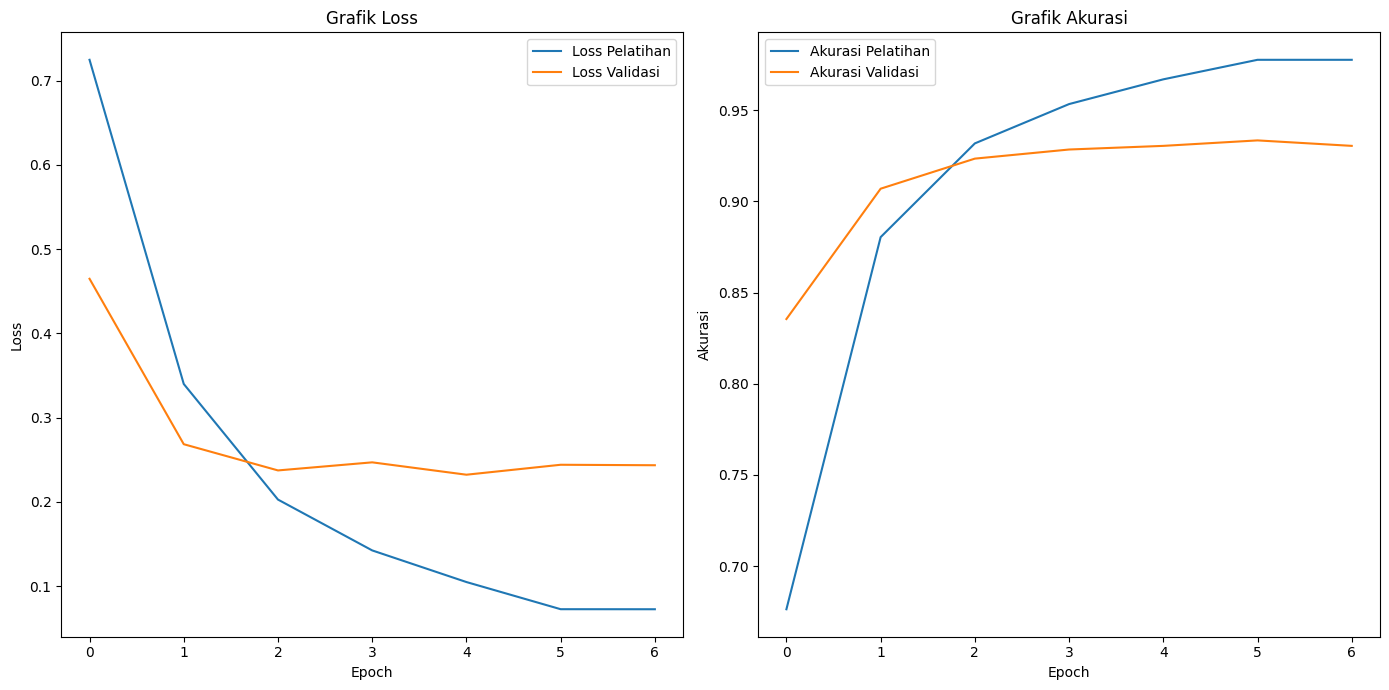

In [76]:
# Visualisasi perkembangan loss dan akurasi selama pelatihan
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot Loss
axes[0].plot(riwayat_latihan.history['loss'], label='Loss Pelatihan')
axes[0].plot(riwayat_latihan.history['val_loss'], label='Loss Validasi')
axes[0].set_title('Grafik Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Akurasi
axes[1].plot(riwayat_latihan.history['accuracy'], label='Akurasi Pelatihan')
axes[1].plot(riwayat_latihan.history['val_accuracy'], label='Akurasi Validasi')
axes[1].set_title('Grafik Akurasi')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Akurasi')
axes[1].legend()

plt.tight_layout()
plt.show()

### Simpan Model

In [77]:
model_LSTM.save(f'{path_model}/model_LSTM.h5')

## Logistic Regression | 80/20 | TF-IDF

### Spliting Data

In [81]:
# Membagi Data menjadi Set Pelatihan dan Pengujian menggunakan train_test_split
X_latih_logreg, X_uji_logreg, y_latih_logreg, y_uji_logreg = train_test_split(
  X_tfidf, y, test_size=0.2, random_state=42
)

# Menampilkan jumlah sampel di setiap subset
print(f"Jumlah Data Train: {X_latih_logreg.shape[0]}")
print(f"Jumlah Data Test: {X_uji_logreg.shape[0]}")

Jumlah Data Train: 16000
Jumlah Data Test: 4000


### Latih Logreg

In [82]:
# Inisialisasi Model Logistic Regression
model_logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Latih Model
model_logreg.fit(X_latih_logreg, y_latih_logreg)

# Lakukan Prediksi
y_pred_logreg = model_logreg.predict(X_uji_logreg)

### Evaluasi Logreg

In [89]:
# Evaluasi Model
akurasi_latih_logreg = accuracy_score(y_latih_logreg, model_logreg.predict(X_latih_logreg))
akurasi_logreg = accuracy_score(y_uji_logreg, y_pred_logreg)

print("Evaluasi Model [Logistic Regression + TF-IDF]\n")
print(f'Akurasi Train: {akurasi_latih_logreg:.4f}')
print(f'Akurasi Test: {akurasi_logreg:.4f}\n')

print(classification_report(y_uji_logreg, y_pred_logreg, target_names=['negatif', 'netral', 'positif']))

Evaluasi Model [Logistic Regression + TF-IDF]

Akurasi Train: 0.8889
Akurasi Test: 0.8233

              precision    recall  f1-score   support

     negatif       0.86      0.87      0.87      1403
      netral       0.75      0.72      0.74      1307
     positif       0.85      0.87      0.86      1290

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



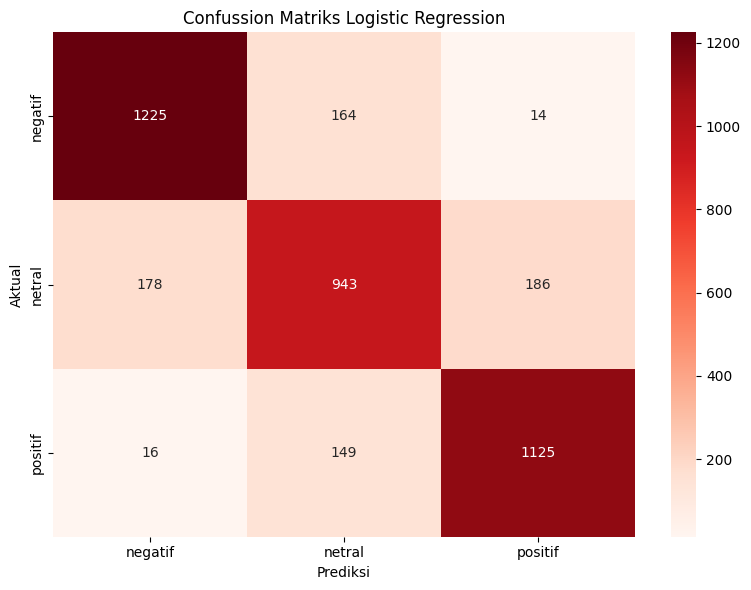

In [99]:
# Plot Confussion Matriks
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_logreg, y_pred_logreg)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confussion Matriks Logistic Regression')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

In [100]:
param_grid = {
  'C': [0.1, 1, 10],  # Penalti regularisasi
  'solver': ['liblinear', 'saga']  # Algoritma solver
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_latih_logreg, y_latih_logreg)

print(f"Best Parameters: {grid_search.best_params_}")
model_logreg_best = grid_search.best_estimator_

Best Parameters: {'C': 10, 'solver': 'saga'}



Evaluasi Model Logistic Regression + TF-IDF dengan Parameter Terbaik

Akurasi Latih: 0.9936
Akurasi Uji: 0.8885

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.94      0.90      0.92      1403
      netral       0.81      0.88      0.85      1307
     positif       0.93      0.88      0.90      1290

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



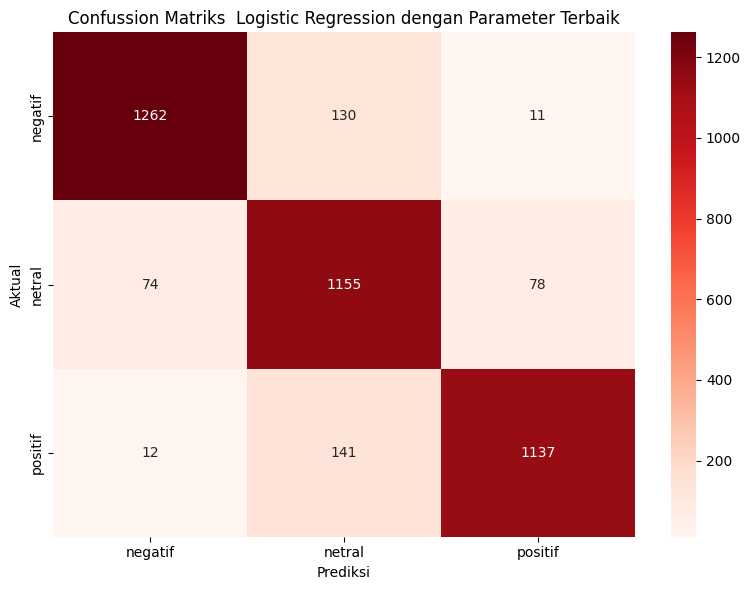

In [104]:
# Inisialisasi Model Logistic Regression dengan Parameter Terbaik
model_logreg_best = LogisticRegression(C=10, max_iter=1000, solver='saga')

# Latih Model dengan Parameter Terbaik
model_logreg_best.fit(X_latih_logreg, y_latih_logreg)

# Lakukan Prediksi
y_pred_logreg_best = model_logreg_best.predict(X_uji_logreg)

# Evaluasi Model dengan Parameter Terbaik
akurasi_latih_logreg_best = accuracy_score(y_latih_logreg, model_logreg_best.predict(X_latih_logreg))
akurasi_logreg_best = accuracy_score(y_uji_logreg, y_pred_logreg_best)

print("\nEvaluasi Model Logistic Regression + TF-IDF dengan Parameter Terbaik")
print(f'\nAkurasi Latih: {akurasi_latih_logreg_best:.4f}')
print(f'Akurasi Uji: {akurasi_logreg_best:.4f}')

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_logreg, y_pred_logreg_best, target_names=['negatif', 'netral', 'positif']))

# Plot Confussion Matriks
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_uji_logreg, y_pred_logreg_best)
sns.heatmap(cm_best,
            annot=True,
            fmt='d',
            cmap='Reds',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confussion Matriks  Logistic Regression dengan Parameter Terbaik')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


Evaluasi Model Logistic Regression dengan C=1.2

Akurasi Latih: 0.9350
Akurasi Uji: 0.8508

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.91      0.87      0.89      1403
      netral       0.76      0.82      0.79      1307
     positif       0.89      0.86      0.87      1290

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



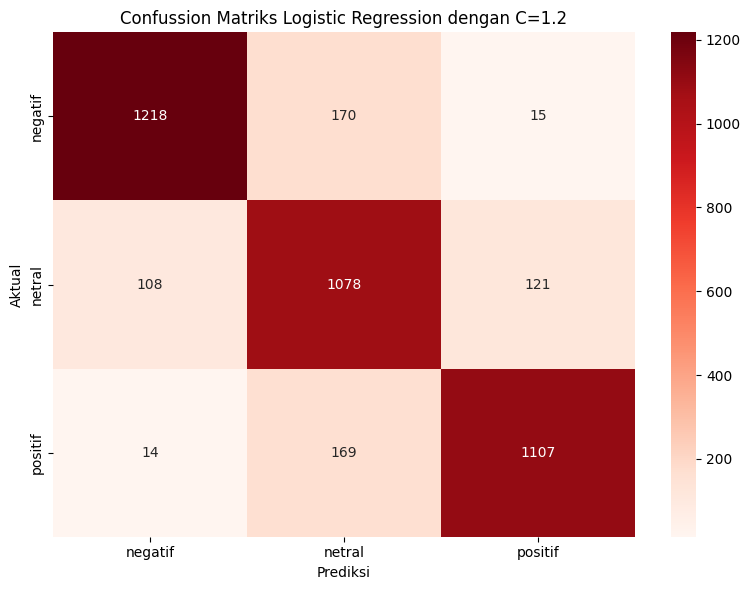

In [103]:
# Coba dengan nilai C lebih rendah
model_logreg_best_2 = LogisticRegression(C=1.2, max_iter=1000, solver='saga')

# Latih Model dengan Parameter Terbaik (C=1.2)
model_logreg_best_2.fit(X_latih_logreg, y_latih_logreg)

# Lakukan Prediksi
y_pred_logreg_best_2 = model_logreg_best_2.predict(X_uji_logreg)

# Evaluasi Model
akurasi_latih_logreg_best_2 = accuracy_score(y_latih_logreg, model_logreg_best_2.predict(X_latih_logreg))
akurasi_logreg_best_2 = accuracy_score(y_uji_logreg, y_pred_logreg_best_2)

print("\nEvaluasi Model Logistic Regression dengan C=1.2")
print(f'\nAkurasi Latih: {akurasi_latih_logreg_best_2:.4f}')
print(f'Akurasi Uji: {akurasi_logreg_best_2:.4f}')

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_logreg, y_pred_logreg_best_2, target_names=['negatif', 'netral', 'positif']))

# Plot Confussion Matriks
plt.figure(figsize=(8, 6))
cm_best_2 = confusion_matrix(y_uji_logreg, y_pred_logreg_best_2)
sns.heatmap(
    cm_best_2,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=['negatif', 'netral', 'positif'],
    yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confussion Matriks Logistic Regression dengan C=1.2')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


### Simpan Model

In [105]:
path_model

'/content/drive/MyDrive/submission/NLP/model'

In [106]:
# Simpan model ke file
joblib.dump(model_logreg_best_2, f'{path_model}/model_logreg.pkl')

['/content/drive/MyDrive/submission/NLP/model/model_logreg.pkl']

## Support Vector Machine | 80/20 | TF-IDF

### Spliting Data

In [107]:
# Membagi Data menjadi Set Pelatihan dan Pengujian menggunakan train_test_split
X_latih_SVM, X_uji_SVM, y_latih_SVM, y_uji_SVM = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Menampilkan jumlah sampel di setiap subset
print(f"Jumlah Data Train: {X_latih_SVM.shape[0]}")
print(f"Jumlah Data Test: {X_uji_SVM.shape[0]}")

Jumlah Data Train: 16000
Jumlah Data Test: 4000


### Latih SVM

In [108]:
# Inisialisasi dan Latih Model SVM dengan kernel linear
model_svm = SVC(kernel='linear', probability=True)

# Latih Model
model_svm.fit(X_latih_SVM, y_latih_SVM)

# Lakukan Prediksi pada Data Pengujian
y_pred_svm = model_svm.predict(X_uji_SVM)

### Evaluasi SVM


Evaluasi Model SVM + TF-IDF

Akurasi Latih: 0.9596
Akurasi Uji: 0.8978

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.95      0.90      0.92      1403
      netral       0.81      0.91      0.86      1307
     positif       0.94      0.89      0.92      1290

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



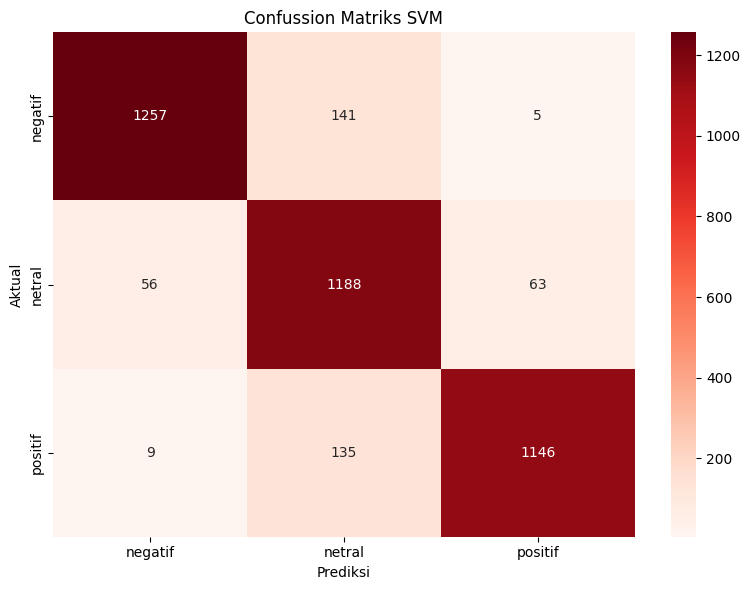

In [109]:
# Evaluasi Model
akurasi_latih_SVM = accuracy_score(y_latih_SVM, model_svm.predict(X_latih_SVM))
akurasi_uji_SVM = accuracy_score(y_uji_SVM, y_pred_svm)

print("\nEvaluasi Model SVM + TF-IDF")
print(f'\nAkurasi Latih: {akurasi_latih_SVM:.4f}')
print(f'Akurasi Uji: {akurasi_uji_SVM:.4f}')

# Laporan Klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_SVM, y_pred_svm, target_names=['negatif', 'netral', 'positif']))

# Plot Confussion Matriks
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_SVM, y_pred_svm)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=['negatif', 'netral', 'positif'],
    yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confussion Matriks SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


### Simpan Model

In [110]:
# Simpan model ke file
joblib.dump(model_svm, f'{path_model}/model_SVM.pkl')

['/content/drive/MyDrive/submission/NLP/model/model_SVM.pkl']

# Perbandingan Model

In [111]:
# Masukkan nilai akurasi yang kamu dapat dari hasil evaluasi
data_akurasi = {
  'Model': ['LSTM', 'Logistic Regression', 'SVM'],
  'Akurasi Latih': [akurasi_latih_terakhir, akurasi_latih_logreg_best_2, akurasi_latih_SVM],
  'Akurasi Uji': [akurasi_uji, akurasi_logreg_best_2, akurasi_uji_SVM]
}

df_akurasi = pd.DataFrame(data_akurasi)
df_akurasi

,Model,Akurasi Latih,Akurasi Uji
0,LSTM,0.977714,0.93300
1,Logistic Regression,0.935000,0.85075
2,SVM,0.959562,0.89775


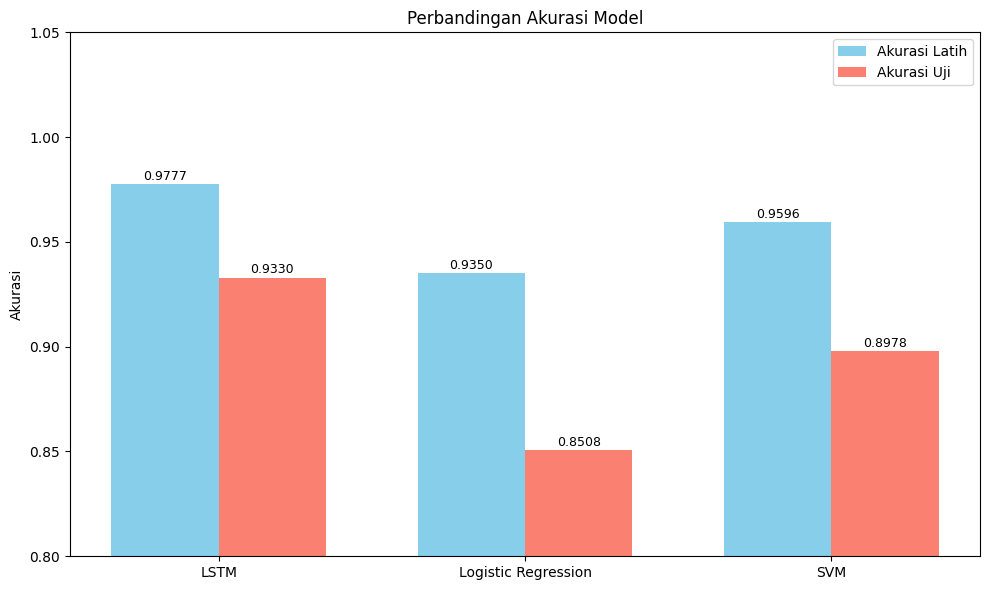

In [113]:
# Visualisasi
x = np.arange(len(df_akurasi['Model']))  # lokasi label
width = 0.35  # lebar bar

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, df_akurasi['Akurasi Latih'], width, label='Akurasi Latih', color='skyblue')
bar2 = ax.bar(x + width/2, df_akurasi['Akurasi Uji'], width, label='Akurasi Uji', color='salmon')

# Label dan tampilan
ax.set_ylabel('Akurasi')
ax.set_title('Perbandingan Akurasi Model')
ax.set_xticks(x)
ax.set_xticklabels(df_akurasi['Model'])
ax.set_ylim(0.8, 1.05)
ax.legend()

# Tampilkan nilai di atas bar
for bars in [bar1, bar2]:
  for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
      xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# requirements.txt

In [ ]:
!pip freeze > /content/drive/MyDrive/submission/NLP/requirements.txt

In [ ]:
!cat /content/drive/MyDrive/submission/NLP/requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.2.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0